In [49]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [50]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [51]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [52]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [53]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [54]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [55]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [56]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [57]:
# Find the most recent date in the data set.
most_recent_date_row = session.query(func.max(measurement.date)).first()
print(most_recent_date_row)

('2017-08-23',)


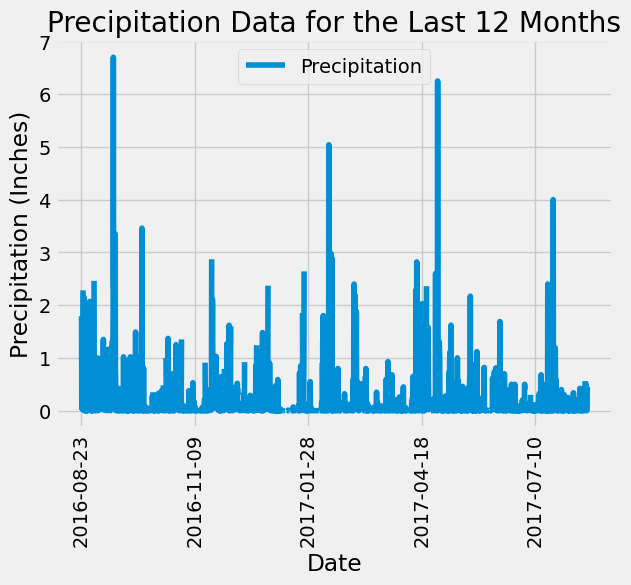

In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Convert the data into a format that's usable for the striptime function
most_recent_date = most_recent_date_row[0]

# Calculate the date one year from the last date in data set (366 days exclusive)
one_year_ago = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(measurement.date, measurement.prcp).filter(measurement.date > one_year_ago).all()

# Save the query results as a Pandas DataFrame with explicitly set column names
df_precip = pd.DataFrame(last_year_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
df_precip = df_precip.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df_precip.plot(x='Date', y='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(rotation=90)
plt.show()

In [59]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = pd.DataFrame(df_precip['Precipitation'].describe())
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [60]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station.station).count()
total_stations

9

In [61]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station).label('observation_count')) \
                        .group_by(measurement.station) \
                        .order_by(func.count(measurement.station).desc()) \
                        .all()

# Not sure if this was needed, but this is the most active (in query form):
# most_active_station = session.query(measurement.station, func.count(measurement.station).label('observation_count')) \
#                         .group_by(measurement.station) \
#                         .order_by(func.count(measurement.station).desc()) \
#                         .first()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [62]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Make a dataframe to hold previous query
df_active = pd.DataFrame(active_stations, columns=['station', 'observation_count'])
df_active

# Find the max count and return the station
most_active_station = df_active.loc[df_active['observation_count'].idxmax()]
most_active_station_id = most_active_station['station']

# Query for the station's data
most_active_results = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)) \
                  .filter(measurement.station == most_active_station_id) \
                  .all()

most_active_results

[(54.0, 85.0, 71.66378066378067)]

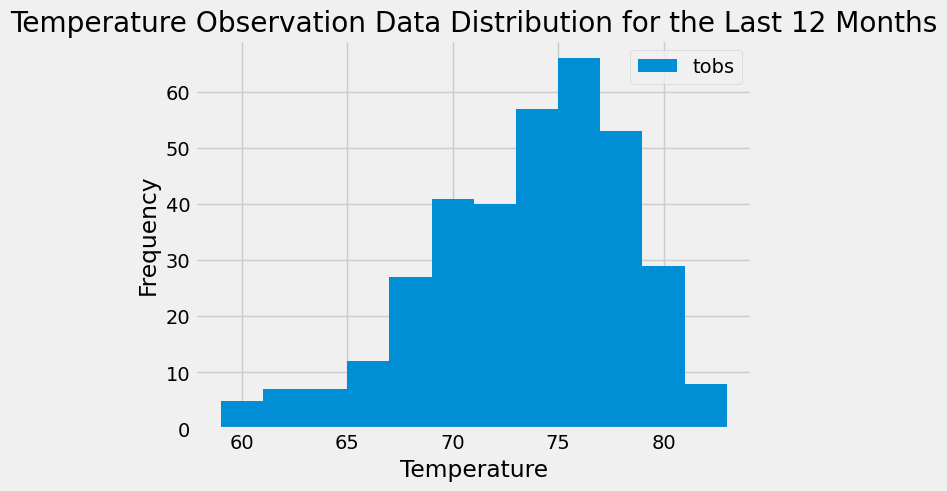

In [63]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= one_year_ago).all()

# Load the query result into a Pandas DataFrame
df_most = pd.DataFrame(most_active, columns=['tobs'])

# Plot the histogram
plt.hist(df_most['tobs'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data Distribution for the Last 12 Months')
plt.legend()
plt.show()

# Close Session

In [64]:
# Close Session
session.close()